Importing relevant libraries

In [24]:
import os
import numpy as np
import pywt
import pandas as pd
import pickle as pkl
from matplotlib import pyplot as plt
import tensorflow as tf
from pywt import scale2frequency
import torch
from ssqueezepy import ssq_cwt, ssq_stft, ssqueezing
import torchvision.transforms.functional as F
import torchvision.transforms as T
from keras.preprocessing.sequence import TimeseriesGenerator
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

## Defining a function for data preparation

Defining function to concatenate all csv files for all bearings folders. Other than concatenation, normalization of the horizontal and vertical values are also done. Creation of a new column, "normalized_rul", was also created using this function.

In [6]:
def read_data_as_df(base_dir):
    
    if base_dir[-1]!='/':
        base_dir += '/'
        
    dfs=[]
    
    counter = 0  # used to calculate curent RUL value
    
    for f in sorted(os.listdir(base_dir)):
        
        # acquiring the total recording time for bearing (each sample is 1 minute)
        total_recording_time_minutes = len(os.listdir(base_dir)) # retrieves the number of samples in one bearing folder.
        
        df=pd.read_csv(base_dir+f)
        
        # normalizing values in the column "Horizontal_vibration_signals"
        hori_mean = df['Horizontal_vibration_signals'].mean()
        hori_sd = df['Horizontal_vibration_signals'].std()
        df['normalized_horizontal'] = (df['Horizontal_vibration_signals']-hori_mean)/hori_sd
        
        # normalizing values in the column "Vertical_vibration_signals"
        vert_mean = df['Vertical_vibration_signals'].mean()
        vert_sd = df['Vertical_vibration_signals'].std()
        df['normalized_vertical'] = (df['Vertical_vibration_signals']-vert_mean)/vert_sd
        
        # calculating the normalized RUL value (RUL divided by total bearing lifetime)
        current_rul = total_recording_time_minutes - counter
        normalized_rul = current_rul/total_recording_time_minutes
        df['normalized_rul'] = normalized_rul
        
        
        dfs.append(df)
        counter += 1
    
    return pd.concat(dfs)

## Don't run the two code cells below

Getting the dataframes for all the bearing folders

In [7]:
#35Hz12kN
bearing1_1 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_1')
bearing1_2 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_2')
bearing1_3 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_3')
bearing1_4 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_4')
bearing1_5 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/35Hz12kN/Bearing1_5')

#37.5Hz11kN
bearing2_1 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_1')
bearing2_2 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_2')
bearing2_3 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_3')
bearing2_4 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_4')
bearing2_5 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/37.5Hz11kN/Bearing2_5')

#40Hz10kN
bearing3_1 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_1')
bearing3_2 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_2')
bearing3_3 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_3')
bearing3_4 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_4')
bearing3_5 = read_data_as_df('C:/Users/thadd/Internship notebooks/Internship dataset (XJTU-SY)/XJTU-SY_Bearing_Datasets/40Hz10kN/Bearing3_5')

saving the dataframes as csv fiels for easier access next time

In [13]:
new_bearing_files = [bearing1_1,bearing1_2,bearing1_3,bearing1_4,bearing1_5\
                    ,bearing2_1,bearing2_2,bearing2_3,bearing2_4,bearing2_5\
                    ,bearing3_1,bearing3_2,bearing3_3,bearing3_4,bearing3_5]

counter = 0

for i in new_bearing_files:
    i.to_csv("new" + str(counter) + ".csv", encoding='utf-8', index=False)
    counter+=1

## sliding window

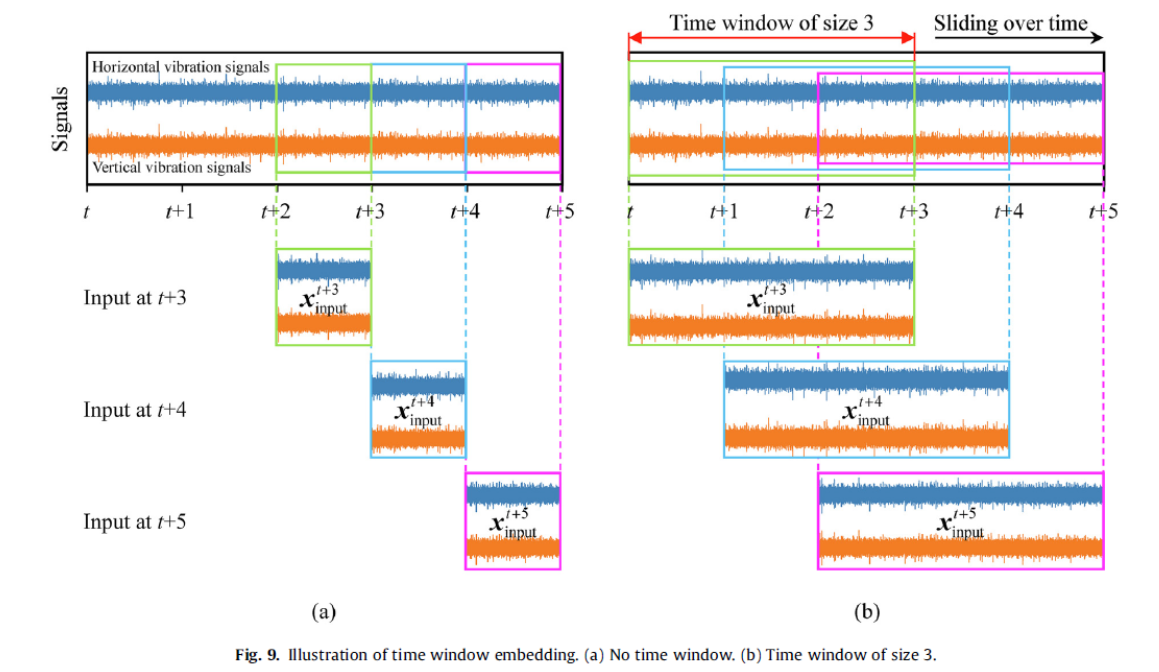

Dataset class is defined below. It takes in 2 arguements "data_dir" which takes a list of directories, and "window_size" which takes the sliding window size.

In [80]:
class XJTUDataset(Dataset):
    '''
    PHM IEEE 2012 Data Challenge Training data set (6 different Mechanical Bearings data)
    '''
    def __init__(self, data_dir = [], window_size = 0): # pass a list of directories for the data you would like to perform sliding window on. Specify the window_size as well.
        
        self.data = {} # defining the dictionary
        x_inputs_list = []
        y_labels_list = []
        
        # reading the data file(s)
        for data in data_dir:
            dataframe = pd.read_csv(data) # "data" contains the directory of the processed bearing file.
            
            # creating a tensor for the X inputs
            x_inputs = torch.tensor([dataframe['normalized_horizontal'],dataframe['normalized_vertical']])
            # unfolding the tensor to perform sliding window
            x_inputs = torch.permute(x_inputs.unfold(1,window_size,window_size), (1, 0, 2))
            
            # creating a tensor for the Y labels
            y_labels = torch.tensor(dataframe['normalized_rul'].unique()) # getting all the unique normalized_rul values.
            y_labels = y_labels.repeat_interleave(int(32768/window_size)) # 32768 is the number of datapoints in one sample. repeat interleave is used to cope with the window size.
            
            # appending the x inputs and y labels.
            x_inputs_list.append(x_inputs)
            y_labels_list.append(y_labels)
            
        # concatenating the x data in self.data['x'] if a list of directories were passed into data_dir=[]. same is done for self.data['y']
        self.data['x'] = np.concatenate(x_inputs_list)
        self.data['y'] = np.concatenate(y_labels_list)[:,np.newaxis]
        
        
    def __len__(self):
        return self.data['x'].shape[0]
    
    def __getitem__(self, i):  # this is to get the sample 
        sample = {'x': torch.from_numpy(self.data['x'][i]), 'y': torch.from_numpy(self.data['y'][i])}
        return sample

In [81]:
# you can pass one data directory as shown here
trial = XJTUDataset(data_dir = ['new_bearing1_1.csv'], window_size = 256)

# and you can pass more than one data directory as shown here
trial = XJTUDataset(data_dir = ['new_bearing1_1.csv','new_bearing1_2.csv'], window_size = 256)